In [2]:
# modules

import numpy as np
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.pardir)

from dataset.mnist import load_mnist
# 本書公式 GitHub (https://github.com/oreilly-japan/deep-learning-from-scratch) で提供されてるモジュール．
# カレントディレクトリに dataset をダウンロードして置いておく，
# あるいは普通にリモートリポジトリごと
# $ git clone https://github.com/oreilly-japan/deep-learning-from-scratch.git
# でローカルに git clone しておく．

# from common.math_functions import *

# %load_ext rpy2.ipython
# rpy2 で R も使いたい場合↑


# 4章 ニューラルネットワークの学習

# 4.1. データから学習する

## 4.1.1. データ駆動

> [p85] コンピュータビジョンの分野で有名な特徴量としては、SIFT や SURF、HOG などが挙げられます。そのような特徴量を使って画像データをベクトルに変換し、その変換されたベクトルに対して、機械学習で使われる識別器―― SVM や KNN など――で学習させることができます。

SIFT や SURF については山﨑先生の講義の第 7,8 回や [qiita](https://qiita.com/icoxfog417/items/adbbf445d357c924b8fc) を参照．回転やスケールにロバストな特徴量(検出器)の代表格．  
つまり例えば，猫の耳が上下左右どっちから写ってても拡大縮小されててもどのくらい拡大縮小されて写ってても，同じような値になってくれる特徴量．

> [p85] ただし、画像をベクトルに変換する際に使用した特徴量は、「人」が設計したものであることに注意が必要です。というのは、問題に応じて適した特徴量を使わなければ(もしくは特徴量 を設計しなければ)、なかなか良い結果が得られないのです。たとえば、犬の顔を見 分けるためには、「5」を認識する特徴量とは別の特徴量を人が考える必要があるかも しれません。つまり、特徴量と機械学習によるアプローチでも、問題に応じて、「人」 の手によって適した特徴量を考える必要があるかもしれないのです。

ビジネス課題 PBL では「体感気温」とか「晴れてる時の気温」とかいう特徴量(交互作用的な)を自分で工夫して作って，それを使って回帰モデル組んで，精度向上(知見発掘)を目指した．まあ確かに，画像とかみたいに生の説明変数の意味が薄いようなデータでこれやるのは，大変．

> [p84] ニューラルネットワークやディープラーニングは、従来の機械学習で使われた手法以上に、人の介入を遠ざけることができるという重要な性質を持ちます。

> [p85] 図4-2 に示すとおり、ニューラルネットワークは、画像を“そのまま”学習します。 2 つ目のアプローチ――特徴量と機械学習によるアプローチ――の例では人が特徴量 を設計しましたが、ニューラルネットワークは，画像に含まれる重要な特徴量までも「機械」が学習するのです

これ，よく言われる表現だが，まあどういう意味での主張か理解できた．  

1. 例えば回帰のニューラルネットワークモデルを考える．  
2. 一般的には，出力層での活性化関数は恒等関数．  すなわち，出力層のノード(アウトカムの値そのもの)は，最後の隠れ層ノードの線形結合になってる．  
3. ここで，一番最後の隠れ層ノードっていうのは，マクロな視点で見ると，説明変数を線形変換・活性化で何度も何度も変換して得られた特徴量である．  データから交互作用をめっちゃ考慮した特徴量を作った感じ．  
4. こう考えると，DNNは「重要な特徴量＝最終隠れ層ノード」を学習で獲得して，それで線形回帰している，とも捉えられる．

このことから

> [p86] ディープラーニングは、「end-to-end machine learning」と呼ばれること があります。ここで言う end-to-end とは、「端から端まで」という意味であ り、これは生データ(入力)から目的の結果(出力)を得ることを意味します。

と言われてるそうだが，前処理(正規化とか白色化)が重要だっていう記述は前にあったし，ハイパラ調整の問題も残ってるし，まだまだ自動化しきれていないと思う．

## 4.2. 損失関数

> [p87,88] ニューラル ネットワークの学習で用いられる指標は、**損失関数** (loss function)と呼ばれます。この損失関数は、任意の関数を用いることができますが、一般には、2乗和誤差や交差エントロピー誤差などが用いられます。

モデルのパラメータ推定のための最適化問題の目的関数のことを，一般に「損失関数(ロス関数，コスト関数)」って言うんだろうな．  
交差エントロピーは使ったことないから理解しよう．

出力(アウトカム)は多次元なので， (4.1) の２乗誤差は

$$
E_i = \frac{1}{2} \sum_{k=1}^K (y_{ik} - t_{ik})^2
$$

という感じで表すのが厳密かな．  
ここで，$K$ は出力の次元 (ノード数) で，$y_{ik}$は $i$ 番目のケースに対する $k$ 番目の出力ノードの値 (確率の予測値)で，$t$ は同様に真のクラスをone-hot-encoding したもので $i$ 番目のケースがクラス $k$ に該当する時は $t_{ik} = 1$ でそれ以外では $0$．こう表した $E_i$ が，$i$ 番目のデータ(観測値,ケース)に対する二乗誤差．  
$\frac{1}{2}$ はなんか計算上の都合だと思う，後でわかりそう．
てか，

> [p88] $y_k$ はニューラルネットワークの出力、$t_k$ は教師データを表し、

っていうノーテーションは PRML と同じだな．いつも $\widehat{y}, y$ を使ってたが，まあハットめんどいしこっちのが楽だな． True の T だし．

In [3]:
def squared_error(y, t):
    return 0.5 * np.sum((y - t)**2)

In [4]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
# y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]

squared_error(np.array(y), np.array(t))

0.09750000000000003

## 4.2.2. 交差エントロピー誤差

２乗誤差の時と同様，出力ノードが多次元なので，

$$
E_i = - \sum_{k=1}^K t_{ik} \log y_{ik}
$$

が $i$ 番目のデータ (ケース) に対する予測の交差エントロピー．  
PRML の p208,209 の (4.108) では「多クラス分類に対する交差エントロピー誤差」という名で同じ定義がある．

「交差エントロピー」という名の意味について考えていく．

まず $y_k$ がここではソフトマックス関数が返した値であることを思い出すと，交差エントロピーの定義に含まれる $-\log y_k$ は「確率 $y_k$ の値(事象)が観測された際に得られる情報量」である (PRLM の 1.92 式)．本来なら「得られる情報量 $-\log y_k$ の期待値」がエントロピーだが (PRML の 1.93 式)，まあその辺の区別せず交差"エントロピー"という名前になってるのだと思う．

PRML の (4.90) にはロジスティックにおける交差エントロピー誤差関数の定義があって，多クラス分類での交差エントロピー(PRML の 4.108)　と見た目違うがやってることは全く同じ．なぜなら，ロジスティックでは $t=0,1$ で2つのクラスを表しているので，(4.90)は「真のクラスが$t=1$のときは $y$ の情報量を足し込んで，真のクラスが $t=0$ のときは $1-y$ の情報量を足しこむ」という操作をやってて，これを多クラスにそのまま拡張したのが (4.108) だから．  
そんで2クラスverの交差エントロピー (4.90) を見ると， クラスベクトル $t$ と出力ベクトル $y$ が交差(クロス)している感じがして， "交差"エントロピーという名も納得．

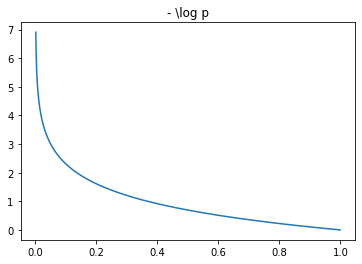

In [5]:
# エントロピー(情報量) log(p) のグラフ
# 珍しい値(事象)ほど観測された時に得られる情報が多い，という思想．PRML参照．

x = np.arange(0.001, 1, 0.001)
y = - np.log(x)

plt.plot(x, y)
plt.title("- \log p")
plt.show()

> そのため、式 (4.2) つまり交差エントロピー誤差は実質的に正解ラベルが 1 に対応する出力の自然対数 (情報量) を計算するだけになります。

ていうの解釈と↑のグラフから考えると，交差エントロピーは損失関数として確かに使える．  
学習の時に微分が使いやすいとか，そういうメリットも後で紹介されるんだと思う．  

まあ強引にクロスエントロピー誤差(の全ケース分の和)の意味を解釈するとしたら「予測(分類)を行った全ケースの真のクラスを観測した時の意外性(驚き度合い, え予測外れてんじゃん度合い)の合計」という感じか．

あと気になる点としては，出力ノードの値が $y < 0$ となった場合はどうしてんだろう．あ，最後の活性化関数にソフトマックスを使えば心配無用か．  
けど，↓の実装では 0 が渡される可能性を考慮して対策してるぽい．

In [6]:
# np.log(0)   # -inf が返される．これだと，定義式中で 0 * -inf の不定形が生じて死ぬかも．
np.log(1e-7)  # 超微小の値を足す．

-16.11809565095832

In [7]:
# def cross_entropy_error(y, t):
#     return - np.sum(t * np.log(y))

def cross_entropy_error(y, t):  
    delta = 1e-7
    return - np.sum(t * np.log(y + 1e-7))

# t=0,y=0 で 0*-inf の不定形が生じるのを防ぐため．
# ソフトマックスを噛ませばこういう心配無いと思うが...

In [8]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
# y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]

cross_entropy_error(np.array(y), np.array(t))

0.510825457099338

## 4.2.3. ミニバッチ学習

> [p91] 先ほど説明した損失関数の例は、ひとつのデータの損失関数を考えてい ました。そこで、訓練データすべての損失関数の和を求めたいとすると、たとえば、 交差エントロピー誤差の場合、次の式 (4.3) のように書くことができます。
$$
E = - \frac{1}{N} \sum_n \sum_k t_{nk} \log y_{nk}
$$

あ，なんだ，この話ここで出てくるのか．  
PRML の p48 を参照．エントロピー(てか情報量)をそのまま足し合わせると言うことは，情報理論的には各観測値の $y_i$ を独立と思っている感じになる．

> [p92] 最後に N で割って正規化しています。こ の N で割ることによって、1 個あたりの「平均の損失関数」を求めることになりま す。そのように平均化すれば、訓練データの数に関係なく、いつでも統一した指標が 得られます。たとえば、訓練データが 1,000 個や 10,000 個の場合であっても、1 個 あたりの平均の損失関数を求められます。

これやっても最適化問題としては変わらない気がするので，まあ，どういうモチベかわからん．ミニバッチ学習の時に必要？  
→ ミニバッチ目的関数で真の目的関数を近似推定してる，みたいな確率的な議論を進める時に便利ぽい． Adam みたいな高度な optimizer の理論とか．6章以降を参照．

> [p92] すべてのデータを対象とした損失関数を計算 するのは、現実的ではありません。そこで、データの中から一部を選び出し、その一 部のデータを全体の「近似」として利用します。ニューラルネットワークの学習にお いても、訓練データからある枚数だけを選び出し――これをミニバッチ(小さな塊) と言う――、そのミニバッチごとに学習を行います。たとえば、60,000 枚の訓練デー タの中から 100 枚を無作為に選び出して、その 100 枚を使って学習を行うのです。 このような学習手法をミニバッチ学習と言います。

こういう問題意識は NN 特有な感じがして，これまで触れてこなかった．  

線形回帰のパラメータ推定で強引に例えてみる．  
目的関数は $(y - X \beta)^T (y - X \beta)$ で，これは $ \beta = (\beta_1, \beta_2, \ldots, \beta_p)^T$ 関数．巨大な $X, y$ から一部の行(観測値)を抜き出して $X_s, y_s$ を作り(これがミニバッチ)，本来最適化したい $(y - X \beta)^T (y - X \beta)$ を計算が軽く済む $(y_s - X_s \beta)^T (y_s - X_s \beta)$　で近似して，こっちについて最適化を行う．そうすると，ちゃんとランダムサンプリングできていれば，低い計算コストで (平均的には) 同じ値の $\widehat{\beta}$ をゲットできる．  
イメージ的には例えば，よく見る 2変数ロジスティックの対数尤度関数の山を，一部のサンプルだけを見て作った山で近似する感じ．

In [9]:
# バッチに対するロス算出を実装したい，試行錯誤

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
print(x_train.shape, t_train.shape, x_test.shape, t_test.shape)
# one_hot_label=True　で，数字ラベルを one hot encoding で取得

print(np.random.choice(10, 3))
%R print( sample(0:9, 3, replace=F))

batch_size = 10
idx = np.random.choice(x_train.shape[0], batch_size)
x_batch = x_train[idx, :]
t_batch = t_train[idx, :]
print(x_batch.shape, t_batch.shape)

(60000, 784) (60000, 10) (10000, 784) (10000, 10)
[2 6 8]


[1] 6 3 0


(10, 784) (10, 10)


In [10]:
 # 入力として，
# - ndim=1 の array (単一の観測値)
# - ndim=2 の array (ミニバッチ)
# の両方を処理できるようにしたいので，どうするかというと...

y = np.array([0, 1, 0, 0])
print(y)
print(y.ndim)
print(y.shape)

y_2d = y.reshape(1, y.shape[0])
print(y_2d)
print(y_2d.ndim)
print(y_2d.shape)

y = np.array([[0.1, 0.3, 0.6], [0.5, 0.4, 0.1]])
t = np.array([[0, 0, 1], [1, 0, 0]])
t*y
t*np.log(y + 1e-7)                                    # 0が入力された時用
- np.sum(t*np.log(y + 1e-7), axis=1)                 # 丁寧に観測値ごとにクロスエントロピーロスを算出して，
np.sum(- np.sum(t*np.log(y + 1e-7), axis=1)) # それを足し合わせる．
- np.sum(t*np.log(y + 1e-7))                              # けどまあ，面倒だから一気に全部足してOK 

[0 1 0 0]
1
(4,)
[[0 1 0 0]]
2
(1, 4)


1.2039724376593033

In [11]:
# 単一観測値(ベクトル)もミニバッチ(行列)も処理できるクロスエントロピー関数．

def cross_entropy_error(y, t):
    if y.ndim == 1:  # ndim=1(ベクトル) つまり単一観測値が入力されたら ndim=2(行列) に整形
        y = y.reshape(1, y.shape[0])
        t = t.reshape(1, t.shape[0])
    return - (1/y.shape[0]) * np.sum(t * np.log(y + 1e-7))

In [12]:
y = np.array([[0.1, 0.3, 0.6], [0.5, 0.4, 0.1]])
t = np.array([[0, 0, 1], [1, 0, 0]])
# y = np.array([0.1, 0.3, 0.6])
# t = np.array([0, 0, 1])

cross_entropy_error(y=y, t=t)

0.6019862188296516

In [13]:
# クラスが one-hot じゃなくてラベルで与えられた時の実装方法を考えるため...

mat = np.array([["00", "01", "02"], ["10", "11", "12"], ["20", "21", "22"]])
mat[[0, 1], [1, 2]]

# おお，こんな感じで「 i 行 j　列と k　行　ｌ 列と... を持ってきてね」という抽出ができるのか．

array(['01', '12'], dtype='<U2')

In [14]:
# クラスが one-hot じゃなくて label のとき用

def cross_entropy_error_label(y, t):
    if y.ndim == 1:
        y = y.reshape(1, y.shape[0])
    return - (1/y.shape[0]) * np.sum(np.log(y[np.arange(y.shape[0]), t] + 1e-7))

In [15]:
y = np.array([[0.1, 0.3, 0.6], [0.5, 0.4, 0.1]])
t = np.array([2, 0])
# y = np.array([0.1, 0.3, 0.6])
# t = 2
# t = np.array([2])

cross_entropy_error_label(y=y, t=t)

0.6019862188296516

## 4.2.5. なぜ損失関数を設定するのか？

> [p95] 私たちが目標とすることは、できるだけ認識精度が高くなるニューラルネッ トワークを獲得することなので、「認識精度」を指標にすべきではないか、という疑 問です。

たしかに，言われてみればこの疑問は自然．実際，決定木だと (推奨はジニ係数とかエントロピーだけど) 誤判別率を不純度として使うことあるよね．

この 4.2.5. の話，全体的に面白い．まとめると...

1. 明らかに，認識精度(誤分類率) は，ある重みパラメータをちょっと動かしただけだと，全く変化しない．
2. つまりパラメータでの微分 (誤分類率の勾配) が，大半の場所で 0 となる．となると，勾配降下(学習, パラメータ探索)できない．
3. 活性化関数が滑らかでないときも，損失関数が滑らかでなくなってしまうので，1.2.と全く同じく学習ができなくなってしまう．

この説明だと，ステップじゃなくてシグモイド(非線型関数)を使うことの理由も人に説明しやすそう．ニューラルネットワーク内の関数のどこか１つでも滑らかじゃない関数があると，そのせいで損失関数も滑らかじゃなくなって，勾配降下できなくなる．

まあもっと砕いた説明をすると，損失関数を容器みたいな感じで見て，そこにボールを入れて底まで届かせることをイメージすれば良い．傾きが０のところがあったら，底までいけない．

# 4.3. 数値微分

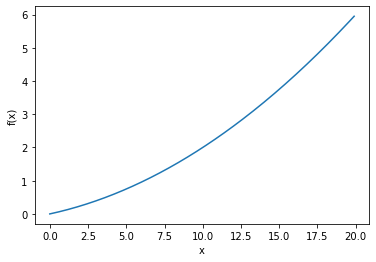

In [16]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

# 解析的に微分すると 0.02*x + 0.1

x = np.arange(0, 20, 0.1)
y = function_1(x)
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

In [18]:
# 数値微分のダメな実装例

def numerical_diff_not(f, x):
    h = 1e-50                              # h を 0 に近づけすぎていて丸め誤差の問題発生
    return (f(x+h) - f(x)) / h

In [19]:
print( numerical_diff_not(function_1, 5) )
print( numerical_diff_not(function_1, 10) )
print( numerical_diff_not(function_1, 100) )
print( numerical_diff_not(function_1, 1000) )

print(function_1(10+1e-50), function_1(10))
print(function_1(10+1e-50) - function_1(10))

# 解析的に求められた勾配と全然一致しない．
# 丸め誤差(ビット数不足でどこかでほんのわずかにある差が丸められて0になってしまった)が原因で微分0．

0.0
0.0
0.0
0.0
2.0 2.0
0.0


In [20]:
# 数値微分の良い例

def numerical_diff(f, x):
    h = 1e-4                                               # 丸め誤差対策で h は大きめ
    return (f(x+h) - f(x-h)) / (2*h)         # 近似精度上げるため前方差分でなく中心差分を使用

In [21]:
print( numerical_diff(function_1, 5) )
print( numerical_diff(function_1, 10) )
print( numerical_diff(function_1, 100) )
print( numerical_diff(function_1, 1000) )
# 解析的な微分とほぼ一致．OK．

print(function_1(10 + 1e-4), function_1(10 - 1e-4))
print(function_1(10 + 1e-4) - function_1(10 - 1e-4))
# 丸め誤差の問題を回避できてるから．

0.1999999999990898
0.2999999999986347
2.1000000001691888
20.099999992453377
2.0000300000999998 1.9999700001
5.999999999972694e-05


## 4.3.3. 偏微分

In [22]:
def function_2(x):
    return x[0]**2 + x[1]**2
#     return np.sum(x**2)

# f(x) = x0^2 + x1^2
# グラフの形は式から明らか．x0,x1いずれかを固定(定数化)すれば 2次関数x^2

In [23]:
# x0=3, x1=4 における勾配を1変数微分 function だけ使って求める． 

def tmp0(x0):  # x1=4 で固定してバサッと切った断面
    return function_2(np.array([x0, 4]))

def tmp1(x1):  # x0=3 で固定してバサッと切った断面
    return function_2(np.array([3, x1]))


print( numerical_diff(tmp0, 3), numerical_diff(tmp1, 4))

6.00000000000378 7.999999999999119


# 4.4. 勾配

In [24]:
# 勾配算出関数の実装の準備

print( np.zeros(3) )

tmpvec = np.array([1,2,3])
tmpmat = np.array([[1,2,3], [4,5,6]])

print( np.zeros_like(tmpvec)  )
print( np.zeros_like(tmpmat) )

# np.zeros_like() ってめっちゃ便利だな．こういう操作すること多い．

print(  np.array([1,2,3]).size                   )
print(  np.array([[1,2,3],[4,5,6]]).size  )
# ndim 問わず全要素数が返されるのか．

[0. 0. 0.]
[0 0 0]
[[0 0 0]
 [0 0 0]]
3
6


In [25]:
# 勾配算出関数．

def numerical_gradient(f, x):
    
    h = 1e-4                                  # 丸め誤差対策で小さくしすぎない
    grad = np.zeros_like(x)         # x(変数ベクトル)と同じ形の array を生成．これを勾配に仕上げる
    
    for idx in range(x.size):         # 変数ベクトルを1次元ずつループ
        
        tmp = x[idx]                 # x[idx] を逃しておく
        
        x[idx] = tmp + h
        fxh1 = f(x)
        
        x[idx] = tmp - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)   # 中心差分で偏微分係数を近似算出して記録
        
        x[idx] = tmp                # x[idx] を元に戻す
        
    return grad

In [26]:
# 動作確認．

numerical_gradient(function_2, np.array([3.0, 4.0]))

# numerical_gradient(function_2, np.array([3, 4]))
# こっちだと全然ダメな結果になった．ちゃんと .0 を打って float として扱わせないとやばい．

array([6., 8.])

In [27]:
# 各地点の勾配を見ながらセルフ勾配降下
# 最小化(降下)したいので，勾配がプラスなら負の方向に動いて，マイナスなら正の方向に動くべき

print( numerical_gradient(function_2, np.array([3.0, 4.0])) )
print( numerical_gradient(function_2, np.array([2.0, 3.0])) )
print( numerical_gradient(function_2, np.array([0.0, 1.0])) )
print( numerical_gradient(function_2, np.array([0.0, 0.0])) )

[6. 8.]
[4. 6.]
[0. 2.]
[0. 0.]


In [28]:
# ch04/gradient_2d.py の「勾配を矢印で表した図 4-9 を生成する」ためのコードを，
# 今後も自分で使いやすいように関数化する．
# 例えばロジスティックの勾配降下を説明する時とかに便利そう．


def numerical_gradient_batch(f, X):  # 複数の座標の勾配を計算する．
    grad = np.zeros_like(X) 
    for idx, x in enumerate(X):       # X の行をループ． 行番号が idx に入り，行ベクトルが x に入る．
        grad[idx, :] = numerical_gradient(f, x)
    return grad


def plot_grad_2d(f, x_range, y_range, sep, sign=1):
    """ 2変数関数の勾配を矢印で可視化
    
    図 4-9 みたいな図を作成する関数．
    いろんな場面で使えそう．
    
    Args:
      f: 勾配を求めたい関数
      x_range: 第１変数(x軸)の範囲
      y_range: 第2変数(y軸)の範囲
      sep: 矢印を出す刻み幅
      sign: 1なら勾配ベクトルの方向，-1なら逆の方向(傾斜をくだる方向)
      
    Returns:
      なし．図を出力．
    
    """
    
    x = np.arange(x_range[0], x_range[1], sep)  # x 軸の刻み
    y = np.arange(y_range[0], y_range[1], sep)  # y 軸の刻み

    X, Y = np.meshgrid(x, y)      # 全格子点の x 座標が X に， y 座標が Y に． [参考](https://deepage.net/features/numpy-meshgrid.html)
    # print(X, Y)                             # X , Y の [i , j] が　i 行 j　列の格子に対応
    # print(X.shape, Y.shape)

    X = X.flatten()                       # vec してベクトルに変換
    Y = Y.flatten()
    # print(X, Y)      # X,Yの対について勾配を求めて可視化すれば良い．
    # print(X.shape, Y.shape)
    
    grad = numerical_gradient_batch(f, np.array([X, Y]).T)
    # np.array([X, Y]) を .T で転置し， 行が case　で列が変数の形にし， 勾配計算関数に渡す

    plt.figure()  # 初期化的な．なくても良いかも．

    plt.quiver(X, Y, sign * grad[:, 0], sign * grad[:, 1],  angles="xy",color="#666666")
    # ベクトル場を plot する plt.quiver．
    # plt.quiver(x座標値, y座標値, ベクトルのx方向の値, ベクトルのy方向の値)
    # angles="xy" は x-y 平面に描画してねという指定．

    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid(linestyle=":")  # メモリの格子線を引く．
    plt.draw()  # 描画の実行的な．なくても良いかも．
    # plt.show()  # 表示的な．なくても良いかも．

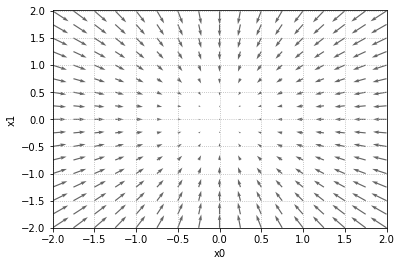

In [29]:
plot_grad_2d(function_2, [-2, 2.01], [-2, 2.01], 0.25, sign=-1)
# numerical_gradient_batch(function_2, np.array([[3.0, 4.0], [2.0, 3.0]]))

> [p105] 勾配は、関数 $f(x_0,x_1)$ の「一番低い場所(最小値)」を指しているようです。 また、「一番低い場所」から遠く離れれば離れるほど、矢印の大きさも大きくなることが分かります。

> [p105, 106] 実際は必ずしもそうなるとはかぎりません。しかし、勾配は、各地点において低くなる方向を指します。より正確に言うならば、勾配が示す方向は、各場所において関数の値を最も減らす方向なのです。

これが勾配法のポイント．  
ある地点の勾配ベクトル (にマイナスかけたもの) は関数値を最も減らす方向を指す．  
（１変数の場合は進む方向がプラスかマイナスかしかないのでイメージしづらい）

砕いた説明としては...

1. 勾配ベクトルの要素である偏微分係数は，他の変数を一定にしてその変数をちょっとプラスに動かす(その次元でちょっとプラスに進む)時の関数の値の変化率である．
2. なので勾配降下法の時は，偏微分係数がマイナスの変数はプラスに動かす(偏微分係数がマイナスの次元ではプラスに進む)べきだし，偏微分係数がプラスの変数はマイナスに動かす(偏微分係数がプラスの次元ではマイナスに進む)べき．勾配上昇法の時は逆．
3. また，複数の変数(次元)のうち，偏微分係数の絶対値が大きい変数は大きめに動かし(偏微分係数の絶対値が大きい次元では大きめに進み)，偏微分係数が小さい変数はそんなに動かさない(偏微分係数の小さい次元ではそんなに進まない)方が，お得(ある一定の距離しか動けないとしたら)．
4. したがって，勾配が示す方向は各場所において関数値を最も減らす(増やす)方向．

という感じ．


## 4.4.1. 勾配法

> [p106] 実際、複雑な関数においては、勾配が指す方向は、最小値ではない場合がほとんどです。

> [p106] 勾配法は勾配が 0 の場所を探しますが、それが必ずしも最小値だとはかぎりません(それは極小値や鞍点の可能性があります)。

などの注意点は当然重要．

勾配降下法は，勾配の情報を使って関数の最小化を目指す(値をなるべく下げる)アルゴリズムの総称(多分)．ここで終了判定を定める必要があり，一般的には「勾配が０(どの方向に動いても関数の値を下げられない)」というのが用いられる．ただ極小値とか鞍点にハマる可能性もあるので「勾配０になっても少しジャンプして関数値が下がる方向があったらそっちに進む」などの工夫の余地もあって，そういう勾配降下法もありそう．

なのでここの「勾配法は勾配が 0 の場所を探します」という表現はちょっと違和感で，あくまで勾配０を終了判定した場合の話．

あと，(性質が良い目的関数なら)勾配０の中のどれかが最小値なので「いろいろなスタート地点から勾配降下していくつかの勾配０を探して，その中で最小なものを採用する」というのもありそう．損失関数だし最小値の存在は多分明らかで，さらに滑らかな関数でモデルを作っておけば損失関数において「最小値ならば極小値で極小値ならば勾配０」は満たされると思うから． 

てか実際，十分な性能が出るんなら最悪ローカルな極小値とかでも問題ないわけだし，

> 勾配の方向が必ず最小値を指すとはかぎらないにせよ、その方向に進むことで関数 の値を最も減らせることができます。そのため、最小値の場所を探す問題――もしく は、できるだけ小さな値となる関数の場所を探す問題――においては、勾配の情報を 手がかりに、進む方向を決めるべきでしょう。

というのは妥当な考え．

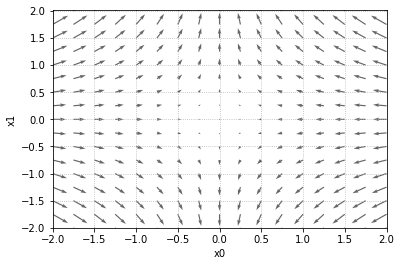

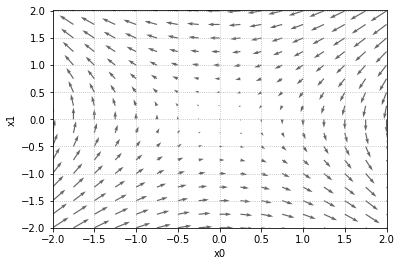

In [30]:
# 鞍点の例 (ここにハマったら嫌)

def func_tmp(x):
    return x[0]**2 - x[1]**2

def func_tmp2(x):
    return x[0]*x[1]

plot_grad_2d(func_tmp, [-2, 2.01], [-2, 2.01], 0.25, sign=-1)
plot_grad_2d(func_tmp2, [-2, 2.01], [-2, 2.01], 0.25, sign=-1)

> [p106] 勾配法では、現在の場所から勾配方向に一定の距離だけ進みます。そして、移動した先でも同様に勾配を求め、また、その勾配方向へ進むというように、繰り返し勾配方向へ移動します。このように勾配方向へ進むことを繰り返すことで、関数の値を徐々に減らす

分かりやすい．厳密には，勾配降下法では勾配ベクトルの逆方向に進み，勾配上昇法では勾配ベクトルの方向に進む．説明としては，さっき書いた

> 1. 勾配ベクトルの要素である偏微分係数は，他の変数を一定にしてその変数をちょっとプラスに動かす(その次元でちょっとプラスに進む)時の関数の値の変化率である．
2. なので勾配降下法の時は，偏微分係数がマイナスの変数はプラスに動かす(偏微分係数がマイナスの次元ではプラスに進む)べきだし，偏微分係数がプラスの変数はマイナスに動かす(偏微分係数がプラスの次元ではマイナスに進む)べき．勾配上昇法の時は逆．
3. また，複数の変数(次元)のうち，偏微分係数の絶対値が大きい変数は大きめに動かし(偏微分係数の絶対値が大きい次元では大きめに進み)，偏微分係数が小さい変数はそんなに動かさない(偏微分係数の小さい次元ではそんなに進まない)方が，お得(ある一定の距離しか動けないとしたら)．
4. したがって，勾配が示す方向は各場所において関数値を最も減らす(増やす)方向．

より，明らか．

勾配降下法は gradient descent method と言って，よく使われるので覚えておく (GDBT の GD とか)

> [p107] 勾配法を数式で表すと次の式 (4.7) のように書くことができます。
$$
\begin{aligned}
x_0 &= x_0 - \eta \frac{\partial f}{\partial x_0}  \\
x_1 &= x_1 - \eta \frac{\partial f}{\partial x_1}
\end{aligned}
$$
式 (4.7) の $\eta$ は更新の量を表します。これは、ニューラルネットワークの学習においては、学習率(learning rate)と呼ばれます。1 回の学習で、どれだけ学習すべきか、どれだけパラメータを更新するか、ということを決めるのが学習率です。
式 (4.7) は 1 回の更新式を示しており、このステップを繰り返し行います。

さっきの説明から明らかなように，勾配上昇法のときは $-$ じゃなくて $+$ にする．  
更新なのでこの $=$ は微妙で，$\leftarrow$ を使うか更新の添字をつけるべき，例えば，

$$
\boldsymbol{x}_{i+1} = \boldsymbol{x}_i - \eta \frac{\partial f}{\partial x}
$$

と書くのが良さそう．（太字が目立たないがベクトル表記）

> [p107] 学習率の値は、0.01 や 0.001 など、前もって何らかの値に決める必要があり ます。この値は、一般的に、大きすぎても小さすぎても、「良い場所」にたどり着く ことができません。ニューラルネットワークの学習においては、学習率の値を変更しながら、正しく学習できているかどうか、確認作業を行うのが一般的です。

さっき説明したように勾配は最も関数の値を減らす(増やす)方向で，各更新でその方向にどのくらい進むかというのが学習率 $\eta$．基本的に，これを大きくすれば収束が速くなるが，極小値の周りを反復してしまって，底(極小値ジャスト)まで落ちずに収束してしまう．[NVIDIAのスライド](https://www.slideshare.net/NVIDIAJapan/01-1000-nvdls18yamasaki)の図が分かりやすい．自然な発想だが，学習(更新)ごとに学習率を変化させていったりもするらしい．

In [31]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    """ 勾配降下法を実行する関数
    
    Args:
      init_x: 初期値
      lr: 学習率(学習率)
      step_num: ステップ(更新)回数．今回は終了判定しないぽい．普通は max_steps とか．
    
    Returns:
      numpy.array (ndim==1): 得られた解
      numpy.array (ndim==2): 更新のログ
    """
    
    x_history = []
    x_history.append(init_x)
    
    for i in range(step_num):
        grad = numerical_gradient(f, x_history[i])
        x_history.append(x_history[i] - lr * grad)
    
    return x_history[-1], np.array(x_history)

In [32]:
x0 = np.array([-3.0, 4.0])

# 学習率が小さすぎると，極小値に収束するまでに時間がかかる．
# (今回は収束判定ないので (0, 0 ) にたどり着くまでのステップ数がかかる )
print( gradient_descent(function_2, init_x=x0, lr=0.01, step_num=100)[0] )
print( gradient_descent(function_2, init_x=x0, lr=0.01, step_num=200)[0] )
print( gradient_descent(function_2, init_x=x0, lr=0.01, step_num=500)[0] )
print( gradient_descent(function_2, init_x=x0, lr=0.01, step_num=1000)[0] )

# 学習率が大きすぎると，極小値のまわりを反復して底に落ちない．
print( gradient_descent(function_2, init_x=x0, lr=10, step_num=1000)[0] )

print( gradient_descent(function_2, init_x=x0, lr=0.1, step_num=100)[0] )

[-0.39785867  0.53047822]
[-0.05276384  0.07035179]
[-0.00012307  0.0001641 ]
[-5.04890207e-09  6.73186943e-09]
[-2.58983747e+13 -1.29524862e+12]
[-6.11110793e-10  8.14814391e-10]


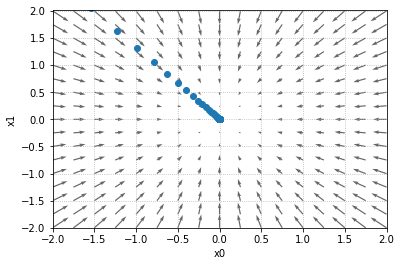

数値解：[-6.11110793e-10  8.14814391e-10]


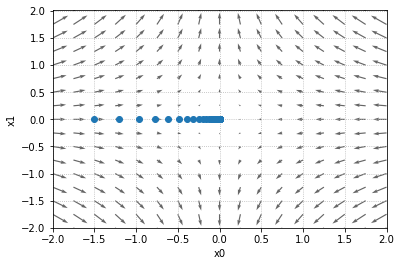

数値解：[-3.05555396e-10  0.00000000e+00]


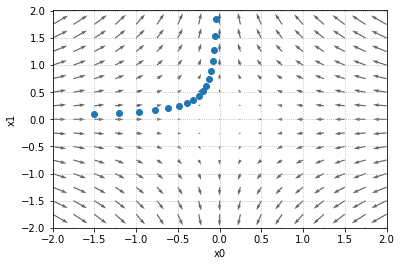

数値解：[-3.00885479e-06  8.28178298e+06]


In [33]:
# うまくいく簡単なパターン
plot_grad_2d(function_2, [-2.0, 2.01], [-2.0, 2.01], 0.25, sign=-1)
res = gradient_descent(function_2, init_x=np.array([-3.0, 4.0]), lr=0.1, step_num=100)
plt.plot(res[1][:, 0], res[1][:, 1], "o")
plt.show()
print("数値解：" + str(res[0]))

# 鞍点にハマるパターン
plot_grad_2d(func_tmp, [-2.0, 2.01], [-2.0, 2.01], 0.25, sign=-1)
res = gradient_descent(func_tmp, init_x=np.array([-1.5, 0.0]), lr=0.1, step_num=100)
plt.plot(res[1][:, 0], res[1][:, 1], "o")
plt.show()
print("数値解：" + str(res[0]))

# 鞍点にハマらないパターン
plot_grad_2d(func_tmp, [-2.0, 2.01], [-2.0, 2.01], 0.25, sign=-1)
res = gradient_descent(func_tmp, init_x=np.array([-1.5, 0.1]), lr=0.1, step_num=100)
plt.plot(res[1][:, 0], res[1][:, 1], "o")
plt.show()
print("数値解：" + str(res[0]))


> [p109] 学習率のようなパラメータはハイパーパラメータと言います。これは、ニューラルネットワークのパラメータ――重みやバイアス――とは性質の異なるパラ メータです。なぜなら、ニューラルネットワークの重みパラメータは訓練データと学習アルゴリズムによって“自動”で獲得されるパラメータであるのに対して、学習率のようなハイパーパラメータは人の手によって設定されるパラメータだからです．

集中講義の時に坂巻先生が「学習率もハイパラって言ってCVとかで調整するのはなんか違和感」と言ってたが，確かに．統計モデルだとハイパーパラメータは「モデルの形状を決定する何らかの値」という感じ．多項式回帰の次数とか， lasso の $\lambda$ (事前ガウス分布の分散)とか， SVM のカーネルとか， RF の木の数とか．

## 4.4.2. ニューラルネットワークに対する勾配

> [p110] 形状が 2 × 3 の重み $W$ だけを持つニューラルネットワーク

これは，入力層２つで出力層３つの単層(１層)ニューラルネットワーク．

> [p110] 勾配は $\frac{\partial L}{\partial W}$ と表すことができます。
$$
\frac{\partial L}{\partial W} =  
\left(
\begin{matrix} 
\frac{\partial L}{\partial w_{11}} & \frac{\partial L}{\partial w_{12}} & \frac{\partial L}{\partial w_{13}} \\ 
\frac{\partial L}{\partial w_{21}} & \frac{\partial L}{\partial w_{22}} & \frac{\partial L}{\partial w_{23}}
\end{matrix}
\right)
$$

これはベクトル微分(勾配ベクトル)と同じような行列微分(勾配行列)．

In [107]:
# この単層ニューラルネットのクラス simpleNet の実装は，やらない．
# 練習用のやつで，実用的に動かしたりしないから．

# 4.5. 学習アルゴリズムの実装

> [p113] 訓練データの中からランダムに一部のデータを選び出す。その選ばれたデータをミニバッチと言い、ここでは、そのミニバッチの損失関数の値を減らすことを目的とする。

> [p113] 使用するデータはミニバッチとして無作為に選ばれたデータを使用していることから、確率的勾配降下法(stochastic gradient descent)という名前で呼ばれます。... 確率的勾配降下法は、「無作為に 選び出したデータに対して行う勾配降下法」という意味になります。... 英語の頭文字を取って SGD という名前の関数で実装されるのが一般的です。

4.2.3 でミニバッチ学習は既に扱ったが，その subset である SGD について確認．

本来パラメータ更新 (勾配降下) に使いたいのは当然「巨大な訓練データ全体に対する損失関数の勾配」である．だって全体に対する損失関数を最小化したいから．だが，この全体勾配を毎回の更新で求めるのは計算コスト的に辛い．

そこで，計算を軽く済ませるために，訓練データから一部(ミニバッチ)を取り出して「ミニバッチだけから算出した損失関数の勾配」を求める．

このミニバッチ勾配で全体勾配を近似できていると想定し，これを使って勾配降下を行う．つまりミニバッチ勾配の方向にパラメータを更新する．ランダムサンプリングできていれば，全体勾配を使った時と (平均的には)　同じ更新をできているはず．

この更新を，使うミニバッチを変えながら，何度も何度も繰り返す．  


## 4.5.1. 2層ニューラルネットワークのクラス

In [34]:
def numerical_gradient(f, x):
    """ナイーブな数値微分で勾配を求める
    
    これまでに作った numerical_gradient() はベクトルを引数に取る関数だけが対象だった．
    ここでは，行列(重み係数W)を引数に取る関数(損失関数)の勾配も求められるようにする．
    
    Args:
      f: 勾配を求めたい関数．
      x: 勾配を求めたい地点 
    
    """
    h = 1e-4                            # 丸め誤差に注意し小さすぎない値
    grad = np.zeros_like(x)  #  勾配は変数と同じ形状．入力が行列な関数には勾配行列を求める．
    
    it = np.nditer(x, flags=['multi_index'])
    # 勾配を求めたい座標値 x をイテレータ化．
    # 全ての要素を順番に取り出せるので，多重ループ(行列なら2重)を書くことなく，
    # ↓のように１重 while ループで簡潔に書ける．
    
    while not it.finished:           # イテレータの最後にたどり着くまでループ
        
        idx = it.multi_index        # 元の行列 x の何行何列か
        tmp_val = x[idx]            # 変数 x_{idx} の元の値を逃しておく
        
        x[idx] = tmp_val + h     # 変数 x_{idx} を元の値からちょっとプラスにずらして，
        # ( TwoLayerNet で呼び出される時は，
        #   内部状態 self.params が書き換えられる． )
        
        fxh1 = f(x)                     # その位置での関数値を取得．
        # ( TwoLayerNet で呼び出される時は，ここで渡した変数 x は f() 内で使われず，
        #   内部状態 self.params に変数(つまりパラ値)が入っててそれが使われる．
        #   なので仮引数 x に self.params を渡しておいて，
        #   ↑の x[idx] = tmp_val + h　で内部状態 self.params の値の書き換えをして，
        #   書き換えられた(+h された) self.params がここの f(x) で使われるようにしている． )
        
        x[idx] = tmp_val - h      # 変数 x_{idx} を元の値からちょっとマイナスにずらして ，
        # ( TwoLayerNet で呼ばれる時は内部状態の書き換え )
        
        fxh2 = f(x)                     # その位置での関数値を取得．
        # ( TwoLayerNet で呼ばれる時は渡してる x じゃなくて内部状態が使われる)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)    # 中心差分で偏微分係数を近似算出
        
        x[idx] = tmp_val            # 変数 x_{idx} の値を元に戻す．
        # ( TwoLayerNet で呼ばれる時は，
        #    x が指してる内部状態 self.params の値を書き換えで元に戻している )
        
        it.iternext()                    # イテレータを１つ進めて次の変数を見るようにする． 
        
    return grad

In [35]:
# ↑の numerical_gradient() の動作確認

def func_tmp(x):
    return x[0,0]**2 + x[0,1]**2 + x[0,2]**2 + x[1,0]**2 + x[1,1]**2 + x[1,2]**2

print( func_tmp(x=np.array([[1.0, 1.0, 2.0], [2.0, 1.0, 0]])) )
print( numerical_gradient(func_tmp, x=np.array([[1.0, 1.0, 2.0], [2.0, 1.0, 0]])) )

# OK．　勾配行列をちゃんと求められているぽい．

11.0
[[2. 2. 4.]
 [4. 2. 0.]]


In [36]:
# ↑の numerical_gradient() を作成するための試行錯誤セル


x = np.array([[1,2,3], [4,5,6]])
print( x )

grad = np.zeros_like(x)
print(grad)


# イテレータの作成
it = np.nditer(x, flags=["multi_index"], op_flags=["readwrite"])
print(type(it))
# n-dimensional iterator の略か．
# イテレータ機能を使って， 例えば n 重ループが必要な処理を簡潔に書ける．
# 参考ブログ：https://www.aipacommander.com/entry/2017/05/14/172220
# 公式docs：https://docs.scipy.org/doc/numpy/reference/arrays.nditer.html


# イテレータの基本的な挙動
print(it.multi_index, it.finished)
it.iternext()  # １つ先に進む
print(it.multi_index, it.finished)
it.iternext(); print(it.multi_index, it.finished)
it.iternext(); print(it.multi_index, it.finished)
it.iternext(); print(it.multi_index, it.finished)
it.iternext(); print(it.multi_index, it.finished)
it.iternext(); print(it.finished)  # 最後まで来ててもう next できない時は True　となる．


# イテレータ(の .finished) と while を組み合わせて多重ループをシンプルに！
it = np.nditer(x, flags=["multi_index"], op_flags=["readwrite"])
while not it.finished:
    print(it.multi_index)
    it.iternext()
        
    
# flags=["multi_index"] は， 多次元 array でイテレータする時の必須の指定だった．
# it = np.nditer(x)
# while not it.finished:
#     print(it.multi_index)
#     it.iternext()


# fイテレータをループすると n 次元配列の各要素を多重ループ使わず１重で取り出せる．
# ここで flags=["multi_index"] はあってもなくても変わらなかった．
it = np.nditer(x, op_flags=["readwrite"])
for i in it:
    print(i)


# op_flags=["readwrite"] を指定するとイテレータ(が指すオブジェクト?)を書き換えできる？
# これを指定しないで書き換えをしようとするとエラー．
# https://docs.scipy.org/doc/numpy/reference/arrays.nditer.html の説明書き参照．
# i[...] に代入すると「 i という変数(ポインタ)の定義」じゃなくて i が指すオブジェクトの書き換えができる
print(x)
it = np.nditer(x, op_flags=["readwrite"])
for i in it:
    i[...] = i * 10
print(x)
# it = np.nditer(x)
# for i in it:
#     i[...] = i * 10
# print(x)
# ValueError: assignment destination is read-only

# この場合イテレータ it が指すオブジェクトを書き換えようとしてないから，
#  "readwrite" 無しでもエラー起きず．本書の実装でも "readwrite" 要らないかも．
print(x)
it = np.nditer(x, flags=["multi_index"], op_flags=["readwrite"])
while not it.finished:
    idx = it.multi_index
    x[idx] = x[idx]*10
    it.iternext()
print(x)
it = np.nditer(x, flags=["multi_index"])
while not it.finished:
    idx = it.multi_index
    x[idx] = x[idx]*10
    it.iternext()
print(x)

[[1 2 3]
 [4 5 6]]
[[0 0 0]
 [0 0 0]]
<class 'numpy.nditer'>
(0, 0) False
(0, 1) False
(0, 2) False
(1, 0) False
(1, 1) False
(1, 2) False
True
(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
1
2
3
4
5
6
[[1 2 3]
 [4 5 6]]
[[10 20 30]
 [40 50 60]]
[[10 20 30]
 [40 50 60]]
[[100 200 300]
 [400 500 600]]
[[1000 2000 3000]
 [4000 5000 6000]]


In [37]:
# 2層 NN のクラスを定義．


class TwoLayerNet:
    """ 2層ニューラルネットワークのクラス
    
    中間層(隠れ層)１つの浅めなやつ．
    各層のニューロン数は一般化してるが，活性化関数とか層の数は固定．分類タスク用．
    
    """
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        """ 初期化
        
        Args:
          input_size: 入力層のノード数（生の説明変数の次元）
          hidden_size: 中間層のノード数(学習で獲得させる特徴量の次元)
          output_size: 出力層のノード数（アウトカムの次元）
          weight_init_std: 重みの初期値を発生させる正規分布の標準偏差
        
        """
        self.params = {}
        self.params["W1"] = np.random.normal(
            loc=0, scale=weight_init_std, size=(input_size, hidden_size)
        )
        self.params["b1"] = np.zeros(hidden_size)  # バイアス項は 0 で初期化する
        self.params["W2"] = np.random.normal(
            loc=0, scale=weight_init_std, size=(hidden_size, output_size)
        )
        self.params["b2"] = np.zeros(output_size)
        
    def predict(self, x):
        """ 出力値の算出 ( forward の計算 )
        
        Args:
          x: 説明変数ベクトル
        
        """
        a1 = np.dot(x, self.params["W1"]) + self.params["b1"]
        z1 = sigmoid(a1)
        a2 = np.dot(z1, self.params["W2"]) + self.params["b2"]
        y = softmax(a2)
        return y
    
    def loss(self, x, t):
        """ 損失関数の値を算出
        
        現状のモデル(重み係数)でのクロスエントロピー誤差を算出する．
        重み係数はアトリビュート(状態)として持っている．
        Args:
          x: 損失を計算したい対象データ(ミニバッチ)の説明変数
          t: そのクラスラベル
        
        """
        y = self.predict(x)
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        """ Accuracy を算出
        
        現状のモデル(重み係数)での Accuracy を算出する．よく見る横軸エポック数のグラフ用？
        Args:
          x: Accuracy を計算したい対象のデータの説明変数
          t: そのクラスラベル
        
        """
        y = self.predict(x)  # クラスごとの予測確率ベクトル
        y = np.argmax(y, axis=1)  # 予測クラスの one-hot-encoding ベクトル
        t = np.argmax(t, axis=1)   # t はクラスラベルじゃなくて one-hot-encoding だからこの処理必要．
        acc = np.sum(y == t) / float(x.shape[0])
        return acc
    
    def numerical_gradient(self, x, t):
        """勾配ベクトルを算出
        
        各層の重み係数W1,W2とバイアスb1,b2について，現状の値での勾配を算出する．
        
        Args: 
          x: このミニバッチデータでの損失関数の勾配を求める．計算効率のための近似．
          t: そのクラスラベル
        
        Note:
          実装が若干煩雑なので解説．
          [1] これらのパラメータ値は .params アトリビュートに状態として持っていて，
          .loss() メソッドもその状態をもとに損失関数値を算出している．
          [2] また，呼び出して使いたい numerical_gradient() の中身を読むと，
          引数 x で渡した変数が参照するオブジェクトを，一時的に +h, -h に書き換えて,
          それを引数 f で渡した関数に入力して関数値算出，って感じになっている．
          [1][2]より，今回は，numerical_gradient() の
          引数 x に「ここの状態(パラメータ)を +h, -h に書き換えてね」というのを渡し，
          引数 f に「書き換え後に実行して欲しい引数ナシ関数 def f(): self.loss(x,t)」を渡せば良いが，
          numerical_gradient() の仕様上，引数 x に渡したものが f に入力されてしまうので，
          それを受け取るためだけの(実際には使わない)ダミー引数 W を導入して def f(W): self.loss(x,t) を渡せば良い．
          つまり，
          「ホントは内部状態のパラメータ値を参照してて使わないけど
            仕様に合わせるために使わないダミー引数を持たせたような loss　を出力する関数」
            を作っておいてそれを f に渡す必要がある．一時的なのでラムダ式で定義したほうがスマート．
        
        """
        loss_W = lambda W: self.loss(x, t)  # def loss_W(W): return self.loss(x,t)　の略
        grads = {}
        grads["W1"] = numerical_gradient(f=loss_W, x=self.params["W1"])
        grads["b1"] = numerical_gradient(f=loss_W, x=self.params["b1"])
        grads["W2"] = numerical_gradient(f=loss_W, x=self.params["W2"])
        grads["b2"] = numerical_gradient(f=loss_W, x=self.params["b2"])
        return grads
        

def sigmoid(x):
    return 1/(1+np.exp(-x))


def softmax(x):
    """ softmax function
    
    from score to probability
    
    """
    if x.ndim==1:
        x = x.reshape(1, x.shape[0])
    c = np.max(x, axis=1, keepdims=True)     # オーバーフロー対策
    return np.exp(x - c)/np.sum(np.exp(x - c), axis=1, keepdims=True)



In [38]:
# ↑の TwoLayersNet の実装の際の試行錯誤

print( np.random.randn(4, 2) )
# randn() は標準正規分布専用．標準正規乱数で 4x2 numpy 配列を作ってね，て感じ．

print( np.random.normal(loc=0, scale=1, size=(4, 2)) )
# normal() では平均と分散を指定できる．size で作って欲しい numpy 配列の shape を指定．

# normal はあくまで単変量ガウス分布の乱数を作る関数で，
# 多変量ガウスでやりたい場合は multivariate_normal() を使うぽい．
# http://starpentagon.net/analytics/numpy_norm_rand/

print( np.zeros((2,3)) )

print( np.argmax(np.array([[1,2,1, 3], [0,3,5,1]]), axis=1) )

print( np.array([[1,3,2],[4,3,1]]) == np.array([[1,2,1], [4,3,1]]) )
print( np.sum(np.array([[1,3,2],[4,3,1]]) == np.array([[1,2,1], [4,3,1]])) )

[[ 0.7954038   0.08983075]
 [-0.11207853  0.11835149]
 [-0.05576412 -0.09111047]
 [-1.0882567   1.69699707]]
[[ 1.17085898  0.90593083]
 [ 0.50653795 -0.19203681]
 [-1.07666421  1.07655282]
 [-0.38128407  1.11357558]]
[[0. 0. 0.]
 [0. 0. 0.]]
[3 2]
[[ True False False]
 [ True  True  True]]
4


In [39]:
# TwoLayerNet を試す．

net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print( net.params.keys() )
print( list(map(lambda k: net.params[k].shape, net.params)) )  # 重みパラメータは乱数で初期化されている．

x = np.random.normal(0, 1, (5, 784))  # 乱数発生させた 5 件のテストデータ
y = net.predict(x)
print( y.shape )                                         # (5, 784) の入力に対し (5, 10) の出力を得られている．
print( y )

x = np.random.normal(0, 1, (10, 784))  # 仮想的なミニバッチ訓練データ
t = np.random.normal(0, 1, (10, 10))    # 仮想的なミニバッチ正解ラベル
grads = net.numerical_gradient(x, t)
print( grads.keys() )
print( list(map(lambda k:grads[k].shape, grads)) )  # 勾配ベクトルはパラメータ net.params と全く同じ形式で吐かれる．

# grads["W1"]
# grads["b1"]
# grads["W2"]
print( grads["b2"] )

# バッチサイズ10でも，勾配を求めるのに相当時間かかる．パラメータが1000個強もあるから．
# これが，誤差逆伝搬法へのモチベ．

dict_keys(['W1', 'b1', 'W2', 'b2'])
[(784, 100), (100,), (100, 10), (10,)]
(5, 10)
[[0.10239045 0.10048441 0.10218875 0.09627908 0.10538562 0.09825627
  0.09999449 0.09704635 0.10139596 0.09657863]
 [0.10359835 0.09982065 0.10228906 0.09680603 0.10643486 0.09809497
  0.09968704 0.09713846 0.10088624 0.09524433]
 [0.10405876 0.09959793 0.10233308 0.0952371  0.10612984 0.09828768
  0.09946897 0.09670992 0.10140844 0.09676828]
 [0.10326207 0.09860774 0.10341359 0.09574369 0.10705555 0.09913215
  0.09881318 0.09660139 0.10090972 0.09646093]
 [0.10396149 0.09993039 0.10237677 0.09493767 0.10535123 0.09864914
  0.09974542 0.09634153 0.10065132 0.09805504]]
dict_keys(['W1', 'b1', 'W2', 'b2'])
[(784, 100), (100,), (100, 10), (10,)]
[-0.36702724 -0.01112733  0.39120394 -0.28035899  0.2387618  -0.00235915
 -0.05703374 -0.31305357 -0.11462469  0.51561896]


> `numerical_gradient(self, x, t)` は、数値微分によってパラメータ の勾配を計算します。次章では、この勾配の計算を高速に求める手法につい て説明します。その手法は誤差逆伝播法と言います。誤差逆伝播法を使って求 めた勾配の結果は、数値微分による結果とほぼ同じになりますが、高速に処 理することができます。

実際さっき体感したが，バッチサイズ10でも勾配をを求めるのに相当時間かかる．パラメータが1000個強もあるから．これが，誤差逆伝搬法へのモチベ．

## 4.5.2. ミニバッチ学習の実装

本来 TwoLayerNet クラスのメソッドとして SGD を実装しておくべきな気もするが，本書では for ループを外に書いてその中で各種メソッドを実行することで実装している．

In [56]:
%%time

# 1,2時間かかるので再実行しない． iters_num=100 だと．
# SGD の実装


# 2層 NN のインスタンス作成
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)


# ロス関数の値の推移(降下)を記録する用
train_loss_list = []


# 学習の設定 (ある種のハイパーパラメータ)
iters_num = 100                         # 更新回数
batch_size = 100                       # バッチサイズ
learning_rate = 0.1                    # 学習率 learning rate． 勾配の方向にどのくらい進むか．


# Stochastic Gradient Descent
for i in range(iters_num): 
    
    # ミニバッチの取得
    idx = np.random.choice(x_train.shape[0], batch_size, replace=True)  # 本書に沿って復元抽出にしてる．bootstrap的．
    x_batch = x_train[idx]
    t_batch = t_train[idx]
    
    # (ミニバッチだけに対する損失関数の) 勾配を計算
    grad = network.numerical_gradient(x_batch, t_batch)
    
    # パラメータ W1, b1, W2, b2 のそれぞれを更新(勾配方向に移動)
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # ロス関数の値を記録
    loss = network.loss(x_batch, t_batch)  # x_train, t_train に対するロスを描画したいと思うが，計算コスト的にバッチで我慢．
    train_loss_list.append(loss)

CPU times: user 1min 15s, sys: 808 ms, total: 1min 15s
Wall time: 43.9 s


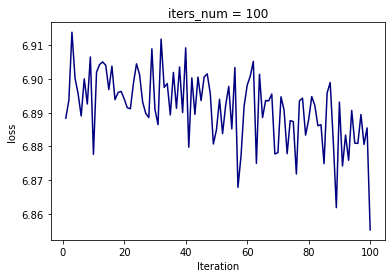

In [93]:
# # SGD での loss の推移を描画．

# plt.figure()
# plt.xlabel("Iteration")
# plt.ylabel("loss")
# plt.title("iters_num = 100")  # 1,2 時間以上はかかってた気がする．

# plt.plot(range(1, iters_num+1), train_loss_list, '-', color="navy")

# plt.show()

# # シンプルに iteration と batch_size が足りてなさそう．
# # !!!!! 後から気づいたが commons につくった softmax() の実装ミスったまま使っていた...
# # ブロードキャストがよろしくやってくれて動いてしまうので逆に注意．

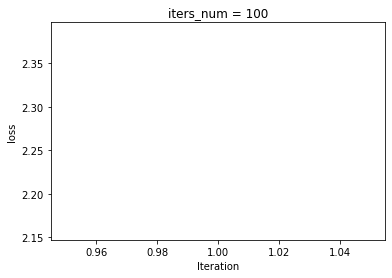

In [55]:
# SGD での loss の推移を描画．
# softmax() の実装ミス修正した ver

plt.figure()
plt.xlabel("Iteration")
plt.ylabel("loss")
plt.title("iters_num = 100")  # 1,2 時間以上はかかってた気がする．

plt.plot(range(1, iters_num+1), train_loss_list, '-', color="navy")

plt.show()


In [112]:
# ↑の SGD 実装の試行錯誤用


network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
print( dir(network) )
# 仕様は def の docstring を参照


print( np.random.choice(10, 12, replace=True) )
print( np.random.choice(10, 12) )
%R print( sample(10, 12, replace=TRUE) )

print( np.random.choice(10, 9, replace=False) )
%R print( sample(10, 9, replace=FALSE) )


idx = np.random.choice(100, 5, replace=True)
x_batch = x_train[idx, :]
t_batch = t_train[idx, :]
print( x_batch, x_batch.shape )
print( t_batch, t_batch.shape )


grad = network.numerical_gradient(x_batch, t_batch)  # バッチに対するロスの勾配を計算
print( grad.keys())
print( list(map(lambda k: grad[k].shape, grad)) )
# 勾配．１本の勾配ベクトルにまとまってるわけではない．

print( network.params.keys() )
print( list(map(lambda k: network.params[k].shape, network.params)) )
# (現在の)パラメータ．算出された勾配 grad と同じ形状になってる．
# なので，勾配降下更新の実装が楽．


updated_params = {}
learning_rate = 0.1

print( network.params["b2"] )  # 勾配降下更新前のパラメータ(初期値)．例として2層のバイアス項
print( grad["b2"] )                      # 勾配ベクトル

for key in network.params:
    network.params[key] = network.params[key] - learning_rate * grad[key]   #　勾配降下による更新．

print( network.params["b2"] )  # 勾配降下更新後のパラメータ．ちゃんと更新式通りにできてる．

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'accuracy', 'loss', 'numerical_gradient', 'params', 'predict']
[5 7 7 2 6 9 7 5 9 7 3 3]
[8 4 5 0 9 2 9 8 6 8 4 1]


 [1]  3 10  7 10  2  3  8  1  8  8  4  3


[6 5 0 1 8 7 2 9 4]


[1]  7  8  5  4  2 10  9  1  3


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (5, 784)
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]] (5, 10)
dict_keys(['W1', 'b1', 'W2', 'b2'])
[(784, 50), (50,), (50, 10), (10,)]
dict_keys(['W1', 'b1', 'W2', 'b2'])
[(784, 50), (50,), (50, 10), (10,)]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-0.09681744 -0.10431775  0.10494162  0.09845514  0.09979931  0.09946142
 -0.09318821 -0.1061048   0.09977824 -0.10200753]
[ 0.00968174  0.01043178 -0.01049416 -0.00984551 -0.00997993 -0.00994614
  0.00931882  0.01061048 -0.00997782  0.01020075]


## 4.5.3. テストデータで評価

> [p119] そもそもニューラルネットワークの学習で目標とすることは、汎化能力を身につけることです。... そこで次の実装では、学習を行う過程で、定期的に訓練データとテストデータを対象に、認識精度を記録することにします。

ちょっとした確認に使うくらいなら良いが「いろんなアーキテクチャの NN でこういうプロット (図4-12) を作って，over fitting していないものを選ぶ」とかやっちゃうと，テストデータに対して over fitting しちゃうことになる．もしそういうことをやるなら，選択したモデルをまた別のデータで最終的な汎化性能をチェックしてあげるべき．

> [p120] エポック(epoch)とは単位を表します。1 エポックとは学習において訓練データをすべて使い切ったときの回数に対応します。たとえば、10,000 個の 訓練データに対して 100 個のミニバッチで学習する場合、確率的勾配降下法を 100 回繰り返したら、すべての訓練データを“見た”ことになります。この場合、100 回= 1 エポックとなります。

つまりエポックっていうのはパラメータ更新をカウントする単位．単位換算式として「1 [epoch] ＝全訓練データサイズ/バッチサイズ [iterations]」が成り立つ．

さっきの SGD の実装では復元抽出ぽいことをしていた (全訓練データをバッチに split するわけじゃなく毎回抽出をやり直してた)．なので「訓練データをすべて使い切った」というのは厳密ではない．ふんわり言うと「訓練データ何周分パラメータを更新したか」がエポック数．

In [129]:
%%time
# SDG の実装 (訓練/テスト　Accuracy も記録する ver)
# 長く学習を回すのは colab で GPU 使わないとしんどい．

# NN モデルを初期化
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)


# 各種記録用の箱を作成
train_loss_list = []             # 訓練データ(バッチ)に対するロス
train_acc_list = []              # 訓練データに対する Accuracy
test_acc_list = []               # テストデータに対する Accuracy


# 学習の設定 (ある種のハイパーパラメータ)
# iters_num = 10000           # エポック単位で指定しないのか．
iters_num = 101
batch_size = 100
learning_rate = 0.1


# サイズの取得
train_size = x_train.shape[0]                                                   # MNIST は n = 60000
iter_per_epoch = max(round(train_size / batch_size), 1)  # 何回の iteration で 1 エポックか． 1エポックあたりの繰り返し回数．
# あとの実装を見ると iter_per_epoch が整数と仮定しちゃってるので， round() を追加．
iter_per_epoch = 10
# MNIST のビッグデータ (n=60000) で何エポック分も回すのは計算コストしんどいので「10回で１エポック」という嘘設定にしてグラフ作る．


# SGD による学習(パラメータ推定)
for i in range(iters_num):
    
    # バッチをサンプリング
    idx = np.random.choice(train_size, batch_size)
    x_batch = x_train[idx, :]
    t_batch = t_train[idx, :]
    
    # 勾配を算出
    grad = network.numerical_gradient(x_batch, t_batch)
    
    for key in network.params.keys():
        network.params[key] -= learning_rate * grad[key]
        
    # iteration ごとに訓練バッチに対するロスを記録
    train_loss_list.append(network.loss(x_batch, t_batch))
    
    # epoch ごとに訓練/テストデータに対する Accuracy を記録
    if i % iter_per_epoch == 0:  # 「何エポック目か」が整数なら記録．添字が0始まりなのを考慮するなら　i+1 が厳密かも．
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("epoch " + str(i // iter_per_epoch) + " : " +
                  "train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

epoch 0 : train acc, test acc | 0.09915, 0.1009
epoch 1 : train acc, test acc | 0.11236666666666667, 0.1135
epoch 2 : train acc, test acc | 0.10441666666666667, 0.1028
epoch 3 : train acc, test acc | 0.09863333333333334, 0.0958
epoch 4 : train acc, test acc | 0.10441666666666667, 0.1028
epoch 5 : train acc, test acc | 0.11236666666666667, 0.1135
epoch 6 : train acc, test acc | 0.10218333333333333, 0.101
epoch 7 : train acc, test acc | 0.11236666666666667, 0.1135
epoch 8 : train acc, test acc | 0.11236666666666667, 0.1135
epoch 9 : train acc, test acc | 0.11236666666666667, 0.1135
epoch 10 : train acc, test acc | 0.20243333333333333, 0.2083


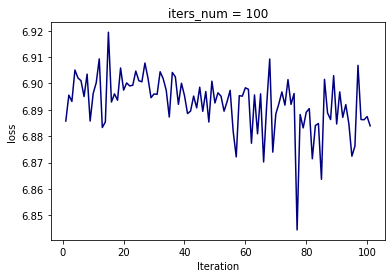

In [134]:
# SGD での loss の推移を描画

plt.plot(range(1, iters_num+1), train_loss_list, '-', color="navy")

plt.xlabel("Iteration")
plt.ylabel("loss")
plt.title("iters_num = 100")  # 1,2 時間以上はかかってた気がする．
plt.show()

# 繰り返し回数とバッチサイズが足りてなさそう．

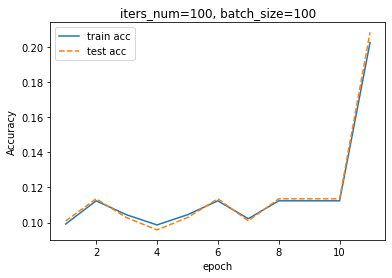

In [139]:
# １エポックごとの 訓練/テスト Accuracy を描画

plt.plot(range(1, len(train_acc_list)+1), train_acc_list, "-", label="train acc")
plt.plot(range(1, len(test_acc_list)+1), test_acc_list, "--", label="test acc")

plt.legend()
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.title("iters_num=100, batch_size=100")
plt.show()

# エポックが足りてないので over fit するとこまでいってない．
# 計算コストのため iters_per_epoch を強引に10で指定したので 図4-12 とは合わない．

> [p121,122] 図 4-12 では、訓練データの認識精度を実線で示し、テストデータの認識精度を破線で示しています。見てのとおり、エポックが進むにつれて(学習が進むにつれて)、訓練データとテストデータを使って評価した認識精度は両方とも向上していることが分かります。また、その 2 つの認識精度には差がないことが分かります(その 2 つの線はほぼ重なっています)。そのため、今回の学習では過学習が起きていないことが分かります。

実際は，図 4-12 みたいにうまく汎化することはあまりなくて，下の図 ( [引用元](http://testpy.hatenablog.com/entry/2017/01/07/164444) ) のような感じで，学習(パラメータ更新)を進めすぎると over fitting が起こる．

ここで関連するテクニックとして **early stopping** がある．これは「over fitting して汎化性能が悪化する前に学習を打ち止め (早期終了) する」という一見強引なやつ．下の図で言うと epoch 数 2000 くらいで Test Accuracy が下がり始めてしまった時に，そこで学習をストップする． このままだともちろんテストデータへの over fitting が懸念されるので，データをあらかじめ訓練・検証・テストの３つに分けておいて， early stopping の判定では検証データを使うべき．

![NNの学習曲線の分かりやすい例](https://cdn-ak.f.st-hatena.com/images/fotolife/S/Shoto/20170107/20170107164129.png)

PRML の 5.5.2 でも early stopping が扱われていて，

> [p259] An alternative to regularization as a way of controlling the effective complexity of a network is the procedure of **early stopping**. ... the error measured with respect to independent data, generally called a validation set, often shows a decrease at first, followed by an increase as the network starts to over-fit. Training can therefore be stopped at the point of smallest error with respect to the validation data set, as indicated in Figure 5.12, in order to obtain a network having good generalization performance.

という感じで，正則化と同様な「モデルの複雑さを制御するためのテクニック」として紹介されている．

講談社MLP「深層学習」でも 3.4 に分かりやすく early stopping が説明されている．「昔からあるテクニック」と言われてる．

> 数値微分による計算には時間がかかるが、その実装は簡単である。一方、次章で実装するやや複雑な誤差逆伝播法は、高速に勾配を求めることができる。

数値微分で勾配を求める場合「+h, -h ずらして n_batch 分の予測値を出して損失関数値を算出して変化率を求める」というのをパラメータの数だけ繰り返さないといけない．１回の勾配計算(勾配方向への降下)をするのに $O(n_{batch}( n_{input} n_{hidden}+ n_{hidden} + n_{hidden}n_{output} + n_{output})$ 回の予測(forward propagation) を行わないといけないので，これを何エポックもやるのはしんどい．